In [27]:
from osgeo import gdal
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pwd = str(pathlib.Path.cwd().parent)

In [3]:
image_path = pwd + "/data/Post_Event_San_Juan.tif"
image_path

'/home/gautam/Documents/Competitions/eye-for-detail/data/Post_Event_San_Juan.tif'

In [4]:
ds = gdal.Open(image_path)
ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f4b8d0c5440> >

In [34]:
ds.GetProjectionRef()

Warning 1: PROJ: proj_create_from_database: Open of /home/gautam/anaconda3/envs/ey-comp/share/proj failed
Warning 1: The definition of projected CRS EPSG:32619 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


'PROJCS["WGS 84 / UTM zone 19N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [32]:
def generate_tiles(input_file, output_dir, grid_x, grid_y):
    ds = gdal.Open(input_file)
    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    x_offset = np.random.randint(0, width - grid_x)
    y_offset = np.random.randint(0, height - grid_y)

    tile_width = min(grid_x, width - x_offset)
    tile_height = min(grid_y, height - y_offset)

    tile = []
    for band in range(1, num_bands + 1):
        tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
        tile.append(tile_data)

    # Create output filename
    output_file = os.path.join(output_dir, f"tile.tif")
        
    # Create an output TIFF file with same CRS and band values range
    driver = gdal.GetDriverByName("GTiff")
    options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
    out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                ds.GetRasterBand(1).DataType, options=options)
    # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

    # Set the geotransform
    geotransform = list(ds.GetGeoTransform())
    geotransform[0] = geotransform[0] + x_offset * geotransform[1]
    geotransform[3] = geotransform[3] + y_offset * geotransform[5]
    out_ds.SetGeoTransform(tuple(geotransform))
    print("Lat?:", geotransform[0])
    print("Lon?:", geotransform[3])

    # Set the projection
    out_ds.SetProjection(ds.GetProjection())

    # Write each band to the output file
    for band in range(1, num_bands + 1):
        out_band = out_ds.GetRasterBand(band)
        out_band.WriteArray(tile[band - 1])

    # Close the output file
    out_ds = None

    print("Tiles generation completed.")
    
def visualize_geotiff(tiff_file):
    if isinstance(tiff_file, str):
        tiff_file = gdal.Open(tiff_file, gdal.GA_ReadOnly) 
    bands = []
    for i in range(1, 4):
        bands.append(tiff_file.GetRasterBand(i).ReadAsArray())
    bands = np.array(bands).transpose(2, 1, 0)
    plt.imshow(bands)
    

# Takes around 5 gb memory so be wary
output_dir = "."
grid_x = 512
grid_y = 512

Total number of tiles: 10730
Lat?: 797531.740235975
Lon?: 2032330.6258482812
Tiles generation completed.


Warning 1: PROJ: proj_create_from_database: Open of /home/gautam/anaconda3/envs/ey-comp/share/proj failed
Warning 1: The definition of projected CRS EPSG:32619 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
ERROR 1: PROJ: proj_create_from_name: Open of /home/gautam/anaconda3/envs/ey-comp/share/proj failed


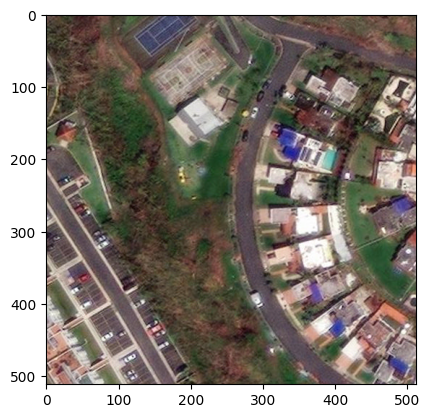

In [33]:
np.random.seed(0)
generate_tiles(image_path, output_dir, grid_x, grid_y)
dataset = gdal.Open('tile.tif', gdal.GA_ReadOnly) 
visualize_geotiff(dataset)

In [13]:
dataset.GetProjectionRef()

'PROJCS["WGS 84 / UTM zone 19N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'